In [1]:
from pathlib import Path
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
#import plotly.graph_objects as go
from transformer_sim import Config, TSTransformer
#import tqdm
import argparse
import metrics
import os   

fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

torch.manual_seed(420)
np.random.seed(430)
torch.manual_seed(420)
np.random.seed(430)

# Overall settings
out_dir = "out_ds_big_norm_5"
# System settings
nu = 7
ny = 14
batch_size = 32 # 256

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 5
compile = False 

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
# torch.set_float32_matmul_precision("high") 
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn


In [2]:
model_path = os.path.abspath("./out_ds_big_norm_5")
list_of_available_models = os.listdir(model_path)

print("These are the available models in "+str(model_path) +":\n")
for i in range(len(list_of_available_models)):
    single_pt_file_path = os.path.join(model_path, list_of_available_models[i]) 
    print("--> ",list_of_available_models[i])

available_models = len(list_of_available_models)

These are the available models in /home/manuel/Scrivania/RoboMorph/Transformer_for_isaac/out_ds_big_norm_5:

-->  ckpt_partition_20_batch16_embd192_heads8_lay12_MSE_ds_big_norm_5.pt


In [3]:
# Create out dir
out_dir = Path(out_dir)

# model_name = list_of_available_models[int(np.random.randint(0,available_models))]

model_name = list_of_available_models[0]
print(" \n TESTING ON: ", model_name)

exp_data = torch.load(out_dir/model_name, map_location="cuda:0")
cfg = exp_data["cfg"]

# # It is possible to test on different scales, even it was trained on a different partition 
# cfg.seq_len_ctx = 200
# cfg.seq_len_new = 500

seq_len = cfg.seq_len_ctx + cfg.seq_len_new

model_args = exp_data["model_args"]
conf = Config(**model_args)
model = TSTransformer(conf).to(device)
model.load_state_dict(exp_data["model"]);

 
 TESTING ON:  ckpt_partition_20_batch16_embd192_heads8_lay12_MSE_ds_big_norm_5.pt


In [4]:
parent_folder = os.path.join(os.getcwd(), os.pardir) 
parent_folder = os.path.abspath(parent_folder)

test_folder = 'test'
try:
    relative_folder = f"./data_generation/out_tensors/{test_folder}"
    tensors_path = os.path.join(parent_folder,relative_folder ) 
    tensors_path = os.path.abspath(tensors_path)
    list_of_available_tensors = os.listdir(tensors_path)

except FileNotFoundError:
    relative_folder = f"Data_generation/python/examples/Franka/out_tensors/{test_folder}"
    tensors_path = os.path.join(parent_folder,relative_folder ) 
    tensors_path = os.path.abspath(tensors_path)
    list_of_available_tensors = os.listdir(tensors_path)

print("These are the available files in "+str(tensors_path) +":\n")
for i in range(len(list_of_available_tensors)):
    single_pt_file_path = os.path.join(tensors_path, list_of_available_tensors[i]) 
    print("--> ",list_of_available_tensors[i])

# index_test = int(np.ceil(torch.rand(1).uniform_(0,int(len(list_of_available_tensors)-1)).numpy()))
index_test = 0
single_pt_file_path = os.path.join(tensors_path, list_of_available_tensors[index_test]) 

print(" \n TESTING ON: ", list_of_available_tensors[index_test])

These are the available files in /home/manuel/Scrivania/RoboMorph/data_generation/out_tensors/test:

-->  5824_envs_1004_steps_1000_f_0_15_MS_rand_1010_bounds_mass_10_10.pt
-->  5258_envs_1007_steps_1000_f_0_15_MS_rand_1010_bounds_mass_10_10.pt
-->  5114_envs_1004_steps_1000_f_0_15_MS_rand_1010_bounds_mass_10_10.pt
 
 TESTING ON:  5824_envs_1004_steps_1000_f_0_15_MS_rand_1010_bounds_mass_10_10.pt


In [5]:
loaded = torch.load(single_pt_file_path,map_location=device) #

def loading():
    control_action_extracted = loaded['control_action'][1:,:,:7]
    position_extracted = loaded['position']
    position = torch.movedim(position_extracted.to('cpu'),-2,-3)
    control_action = torch.movedim(control_action_extracted.to('cpu'),-2,-3)

    position = position[:,:,:]
    return control_action,position
control_action,position = loading()
    
print(control_action.shape)
print(position.shape)

num_test = control_action.shape[0]

torch.Size([1004, 1000, 7])
torch.Size([1004, 1000, 14])


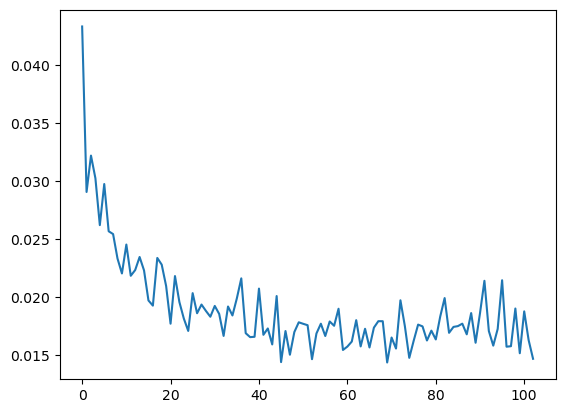

In [11]:
import pandas as pd
loss = exp_data["LOSS"]
loss
pd.Series(loss)
plt.figure()
plt.plot(loss)

In [6]:
#initializing errors 
y_ground_truth = torch.empty(position[:num_test,cfg.seq_len_ctx:seq_len,:].shape,device=device)
y_predicted = torch.empty(position[:num_test,cfg.seq_len_ctx:seq_len,:].shape,device=device)
sim_error = torch.empty(position[:num_test,cfg.seq_len_ctx:seq_len,:].shape,device=device)

# sim_error = torch.empty(position[:,cfg.seq_len_ctx:,:].shape,device=device)

for i in range(num_test): 

    single_u = control_action[i,:seq_len,:]
    single_y = position[i,:seq_len,:]

    single_y = single_y.to(device)
    single_u = single_u.to(device)

    with torch.no_grad():
        single_y_ctx = single_y[:cfg.seq_len_ctx, :]
        single_u_ctx = single_u[:cfg.seq_len_ctx, :]
        single_y_new = single_y[cfg.seq_len_ctx:seq_len, :]
        single_u_new = single_u[cfg.seq_len_ctx:seq_len, :]
        t_start = time.time()
        single_y_sim = model(single_y_ctx.unsqueeze(0), single_u_ctx.unsqueeze(0), single_u_new.unsqueeze(0))
        t_end = time.time()
        single_sim_error = single_y_sim - single_y_new
    
    y_ground_truth[i] = single_y_new
    y_predicted[i] = single_y_sim
    sim_error[i] = single_sim_error

print("Random required time for single simulation:", t_end-t_start)

Random required time for single simulation: 0.012010335922241211


In [ ]:
print(y_ground_truth.shape)
print(y_predicted.shape)
print(sim_error.shape)

t = np.arange(1, single_u_new.shape[0]+1) + cfg.seq_len_ctx
y_ground_truth = y_ground_truth.to("cpu").detach().numpy()
y_predicted = y_predicted.to("cpu").detach().numpy()
sim_error = sim_error.to("cpu").detach().numpy()

torch.Size([32, 800, 14])
torch.Size([32, 800, 14])
torch.Size([32, 800, 14])


In [ ]:
rmse = metrics.rmse(y_ground_truth, y_predicted, time_axis=1)
nrmse = metrics.nrmse(y_ground_truth, y_predicted, time_axis=1)
fit_index = metrics.fit_index(y_ground_truth, y_predicted, time_axis=1)
r_squared = metrics.r_squared(y_ground_truth, y_predicted, time_axis=1)

rmse.shape
# nrmse
# r_squared
# fit_index

(32, 14)

In [ ]:
n_param = sum(map(torch.numel, model.parameters()))
print(f'parameter count: {n_param}')
# print(f'iterations: {exp_data["cfg"].max_iters}')
# print(f'train_time: {exp_data["train_time"]/3600/24} days')
print(f'train_time: {exp_data["train_time"] / 60} minutes')
print(f'rmse: {rmse.mean()}')
print(f'nrmse: {nrmse.mean()}') # strange
print(f'fit_index: {fit_index.mean()}') 
print(f'r_squared: {r_squared.mean()}') 
print(f'r_squared_std: {r_squared.std()}') 

parameter count: 12638222
train_time: 83.52142619689306 minutes
rmse: 0.048717059195041656
nrmse: 0.3929409682750702
fit_index: 60.705902099609375
r_squared: 0.7886306643486023
r_squared_std: 0.2969663441181183


In [ ]:
#R2
r_squared_mean_along_y_dimensions = torch.empty((num_test,1),device = device)
r_squared_std_along_y_dimensions = torch.empty((num_test,1),device = device)
#RMSE
RMSE_mean_along_y_dimensions = torch.empty((num_test,1),device = device)
RMSE_std_along_y_dimensions = torch.empty((num_test,1),device = device)
# NRMSE
NRMSE_mean_along_y_dimensions = torch.empty((num_test,1),device = device)
NRMSE_std_along_y_dimensions = torch.empty((num_test,1),device = device)
# fit index
fit_index_along_y_dimensions = torch.empty((num_test,1),device = device)
fit_index_std_along_y_dimensions = torch.empty((num_test,1),device = device)

for i in range(r_squared.shape[0]):
    r_squared_mean_along_y_dimensions[i]= torch.tensor(r_squared[i,:].mean())
    r_squared_std_along_y_dimensions[i] = torch.tensor(r_squared[i,:].std())

    RMSE_mean_along_y_dimensions[i]= torch.tensor(rmse[i,:].mean())
    RMSE_std_along_y_dimensions[i] = torch.tensor(rmse[i,:].std())

    NRMSE_mean_along_y_dimensions[i]= torch.tensor(nrmse[i,:].mean())
    NRMSE_std_along_y_dimensions[i] = torch.tensor(nrmse[i,:].std())

    fit_index_along_y_dimensions[i]= torch.tensor(fit_index[i,:].mean())
    fit_index_std_along_y_dimensions[i] = torch.tensor(fit_index[i,:].std())

In [ ]:
#R2
r_squared_mean_along_y_dimensions = r_squared_mean_along_y_dimensions.to("cpu").detach().numpy()
r_squared_std_along_y_dimensions = r_squared_std_along_y_dimensions.to("cpu").detach().numpy()
#RMSE
RMSE_mean_along_y_dimensions = RMSE_mean_along_y_dimensions.to("cpu").detach().numpy()
RMSE_std_along_y_dimensions = RMSE_std_along_y_dimensions.to("cpu").detach().numpy()
#NMSE
NRMSE_mean_along_y_dimensions = NRMSE_mean_along_y_dimensions.to("cpu").detach().numpy()
NRMSE_std_along_y_dimensions = NRMSE_std_along_y_dimensions.to("cpu").detach().numpy()
#Fit index
fit_index_along_y_dimensions = fit_index_along_y_dimensions.to("cpu").detach().numpy()
fit_index_std_along_y_dimensions = fit_index_std_along_y_dimensions.to("cpu").detach().numpy()


In [ ]:
# highest is better
minR_squared_idx = np.argmin(r_squared_mean_along_y_dimensions)
maxR_squared_idx = np.argmax(r_squared_mean_along_y_dimensions)

worst_fit_index_idx = np.argmin(fit_index_along_y_dimensions)
best_fit_index_idx = np.argmax(fit_index_along_y_dimensions)

# Lowest is better
worst_RMSE_idx = np.argmax(RMSE_mean_along_y_dimensions)
best_RMSE_idx = np.argmin(RMSE_mean_along_y_dimensions)

worst_NRMSE_idx = np.argmax(NRMSE_mean_along_y_dimensions)
best_NRMSE_idx = np.argmin(NRMSE_mean_along_y_dimensions)


print("Worst R2: " + str(round(r_squared_mean_along_y_dimensions[minR_squared_idx].item(),4))+ f" --> index {minR_squared_idx}")
print("Best R2: " + str(round(r_squared_mean_along_y_dimensions[maxR_squared_idx].item(),4))+ f"  --> index {maxR_squared_idx}")
print("\n")
print("Worst fit index: " + str(round(fit_index_along_y_dimensions[worst_fit_index_idx].item(),4))+ f" --> index {minR_squared_idx}")
print("Best fit index: " + str(round(fit_index_along_y_dimensions[best_fit_index_idx].item(),4))+ f"  --> index {maxR_squared_idx}")
print("\n")
print("Worst RMSE: " + str(round(RMSE_mean_along_y_dimensions[worst_RMSE_idx].item(),5))+ f" --> index {worst_RMSE_idx}")
print("Best RMSE: " + str(round(RMSE_mean_along_y_dimensions[best_RMSE_idx].item(),5))+ f" --> index {best_RMSE_idx}")
print("\n")
print("Worst NRMSE: " + str(round(NRMSE_mean_along_y_dimensions[worst_NRMSE_idx].item(),5))+ f" --> index {worst_RMSE_idx}")
print("Best NRMSE: " + str(round(NRMSE_mean_along_y_dimensions[best_NRMSE_idx].item(),5))+ f" --> index {best_RMSE_idx}")

Worst R2: 0.3386 --> index 23
Best R2: 0.9479  --> index 12


Worst fit index: 27.4119 --> index 23
Best fit index: 78.0852  --> index 12


Worst RMSE: 0.10905 --> index 23
Best RMSE: 0.01702 --> index 12


Worst NRMSE: 0.72588 --> index 23
Best NRMSE: 0.21915 --> index 12


In [ ]:
save_figure = False

labels_coordinates = ["$x$","$y$","$z$" ,"$X$","$Y$","$Z$" ,"$W$","q0","q1","q2","q3","q4","q5","q6"]
labels_pred = ["$\hat x$","$\hat y$","$\hat z$","$\hat X$","$ \hat Y$","$\hat Z$" ,"$ \hat W$"
            ,"$ \hat q0$","$ \hat q1$","$ \hat q2$","$ \hat q3$","$ \hat q4$","$ \hat q5$","$ \hat q6$"]
labels_error = ["$x - \hat x$","$y - \hat y$","$z - \hat z$","$X - \hat X$","$ Y - \hat Y$",
                "$Z - \hat Z$" ,"$ W -  \hat W$","$ q0 -  \hat q0$","$ q1 -  \hat q1$","$ q2 -  \hat q2$"
                ,"$ q3 -  \hat q3$","$ q4 -  \hat q4$","$ q5 -  \hat q5$","$ q6 -  \hat q6$"]

random_idx = int(np.ceil(torch.rand(1).uniform_(0,int(len(RMSE_mean_along_y_dimensions)-1)).numpy()))
# test_idxs = [minR_squared_idx, maxR_squared_idx,random_idx]
# label_idxs =['Worst_R2','Best_R2','random']     

test_idxs = [worst_RMSE_idx, best_RMSE_idx,random_idx]
label_idxs =['Worst RMSE','Best RMSE','random']  

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

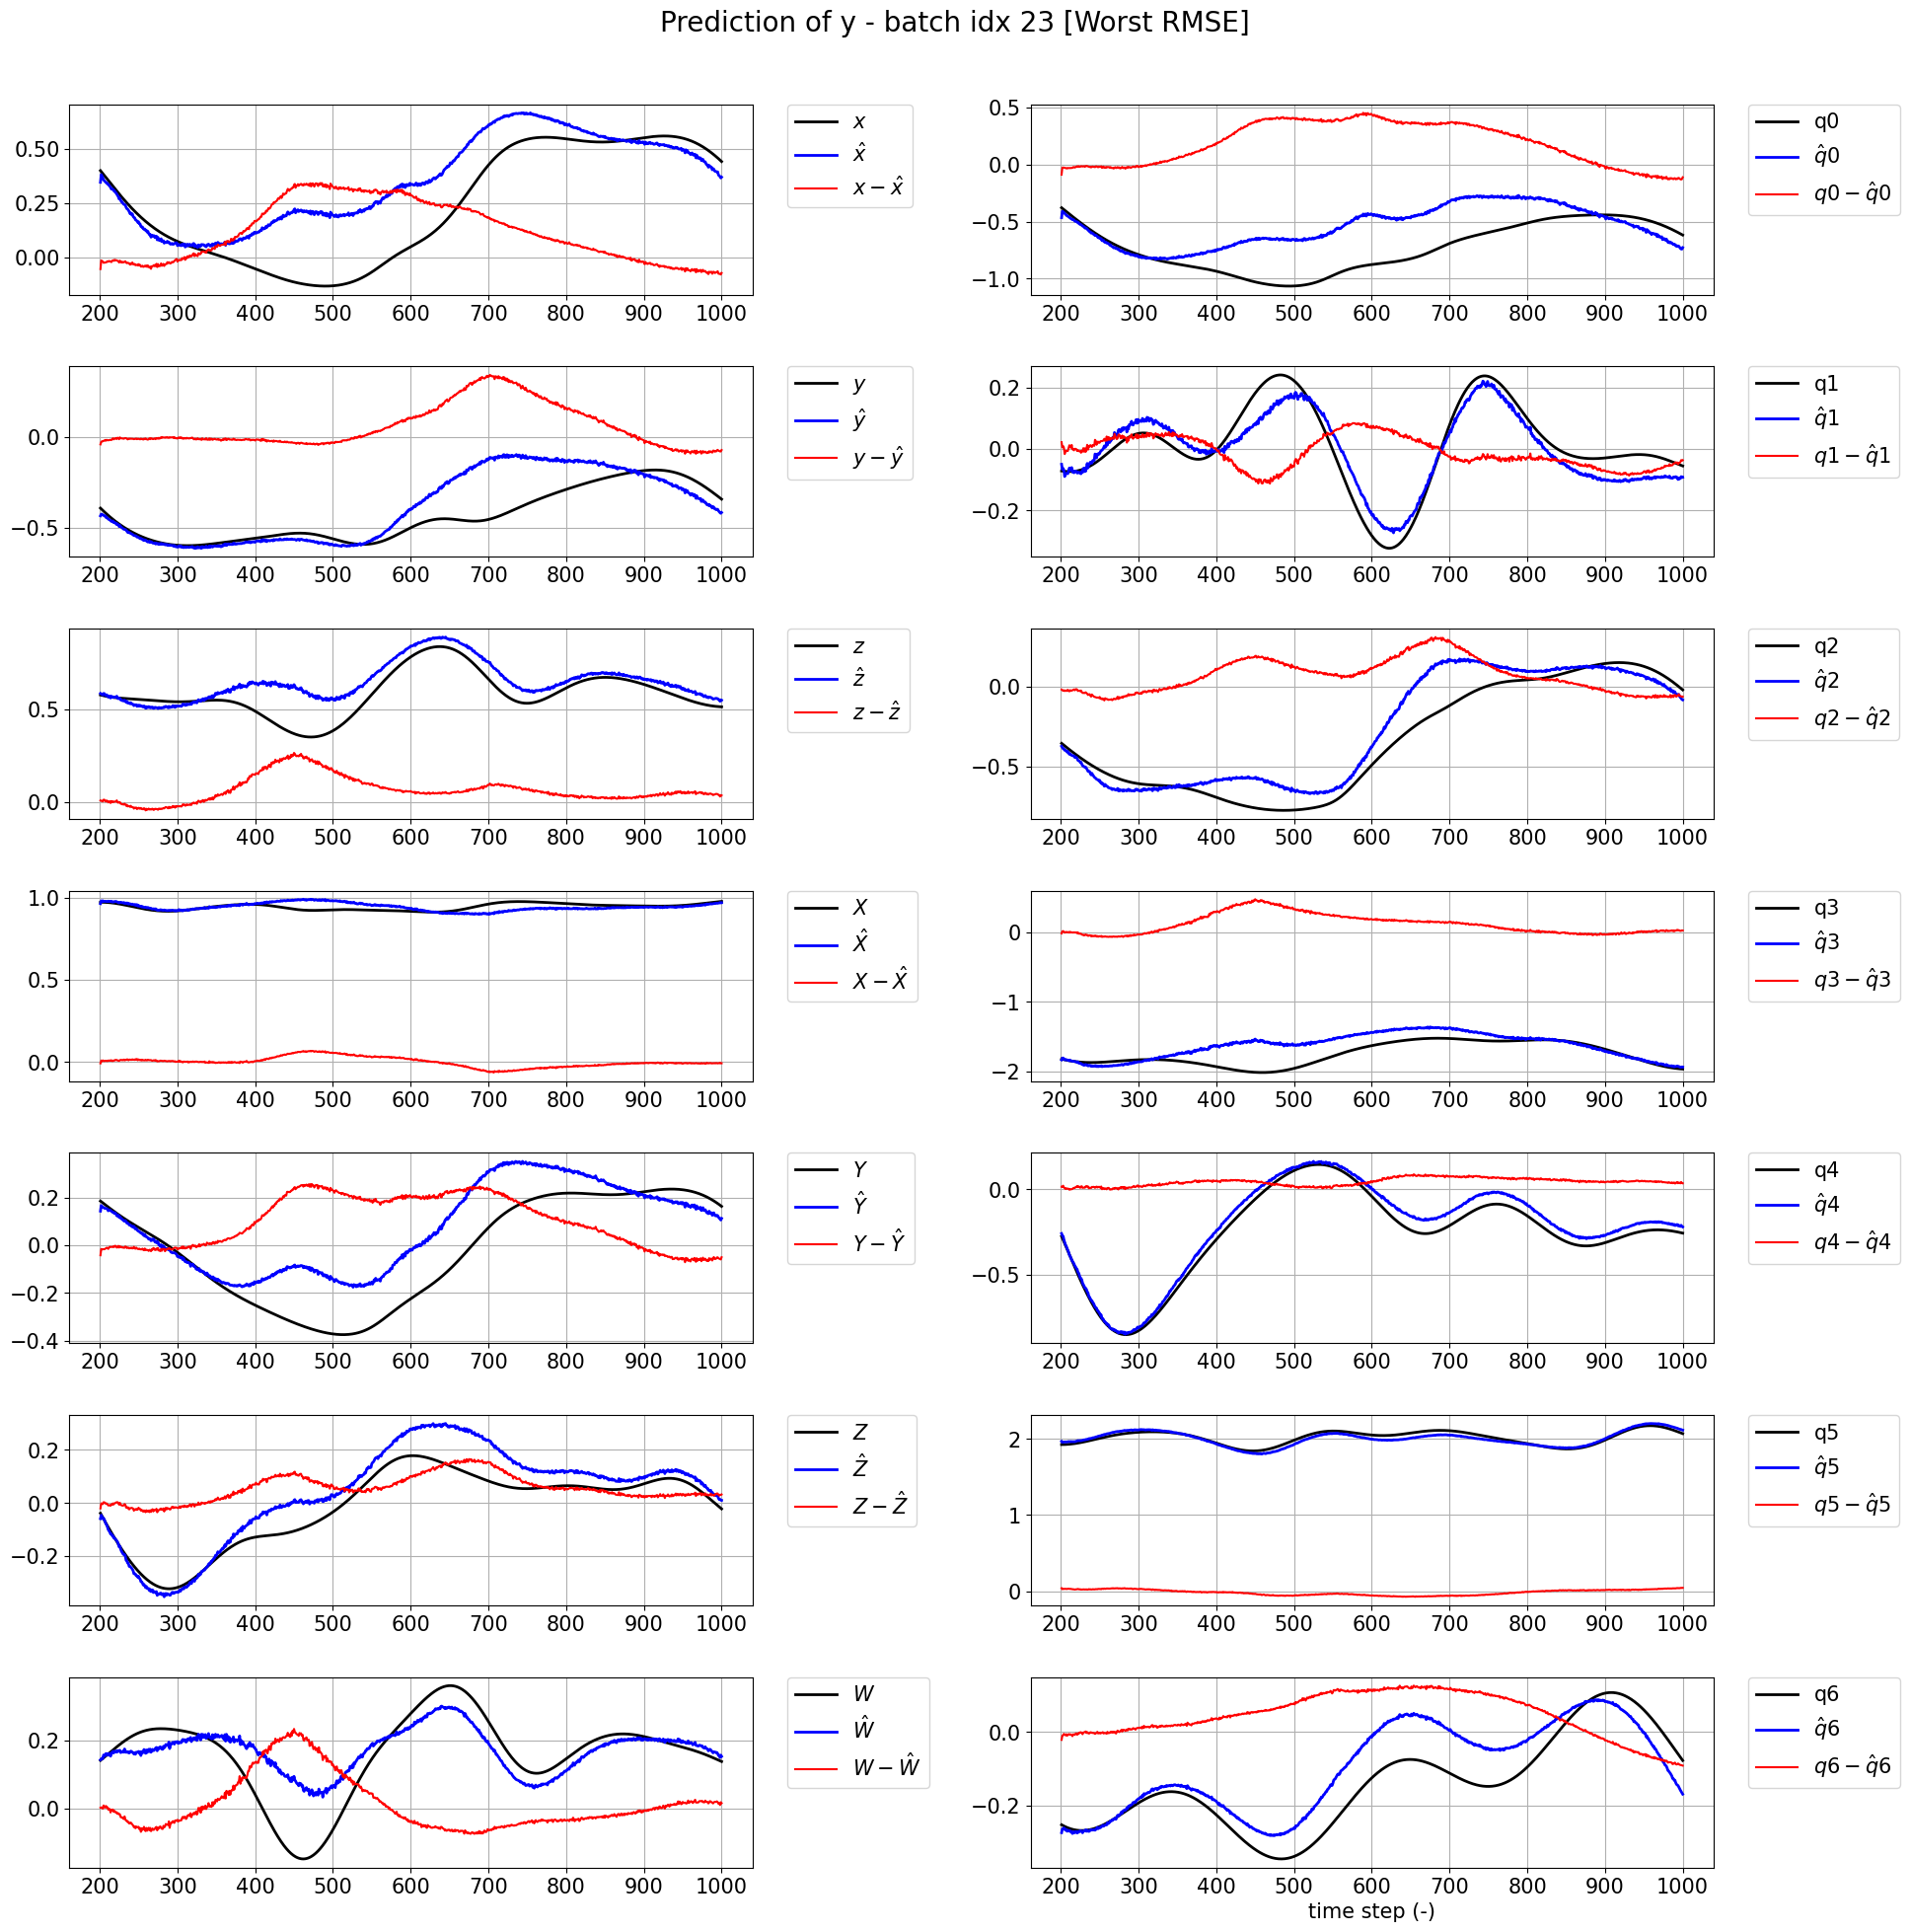

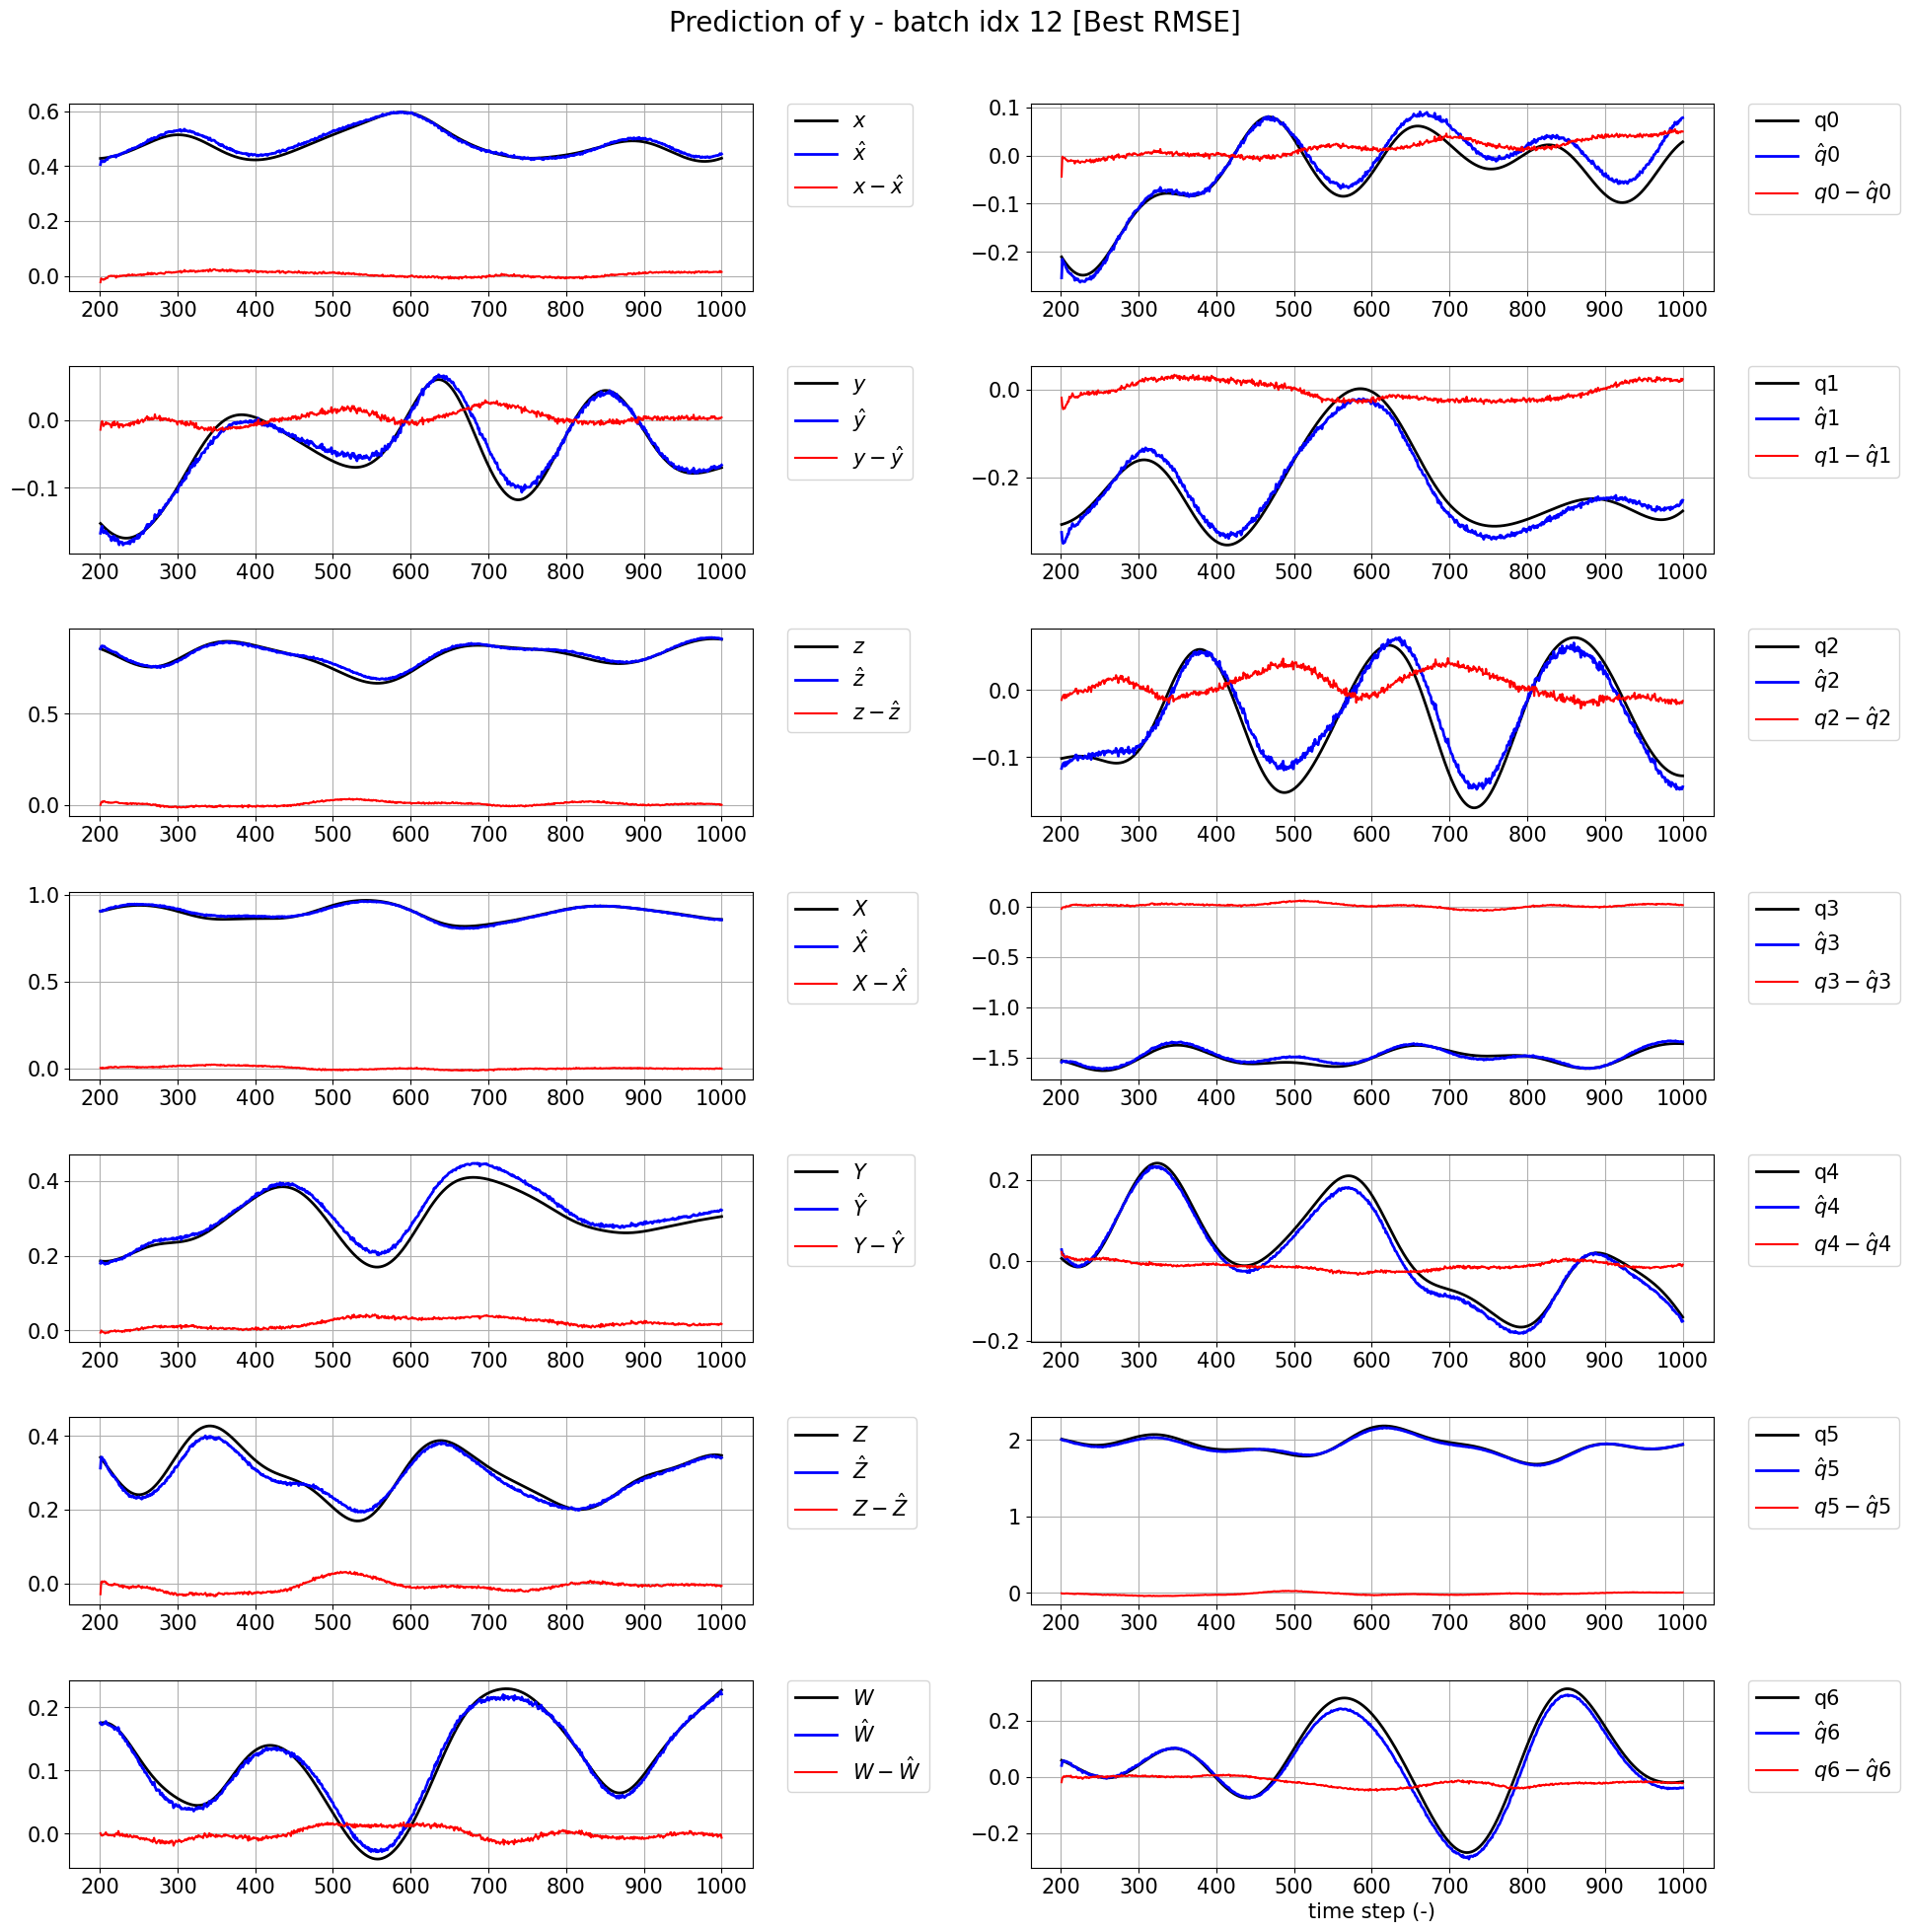

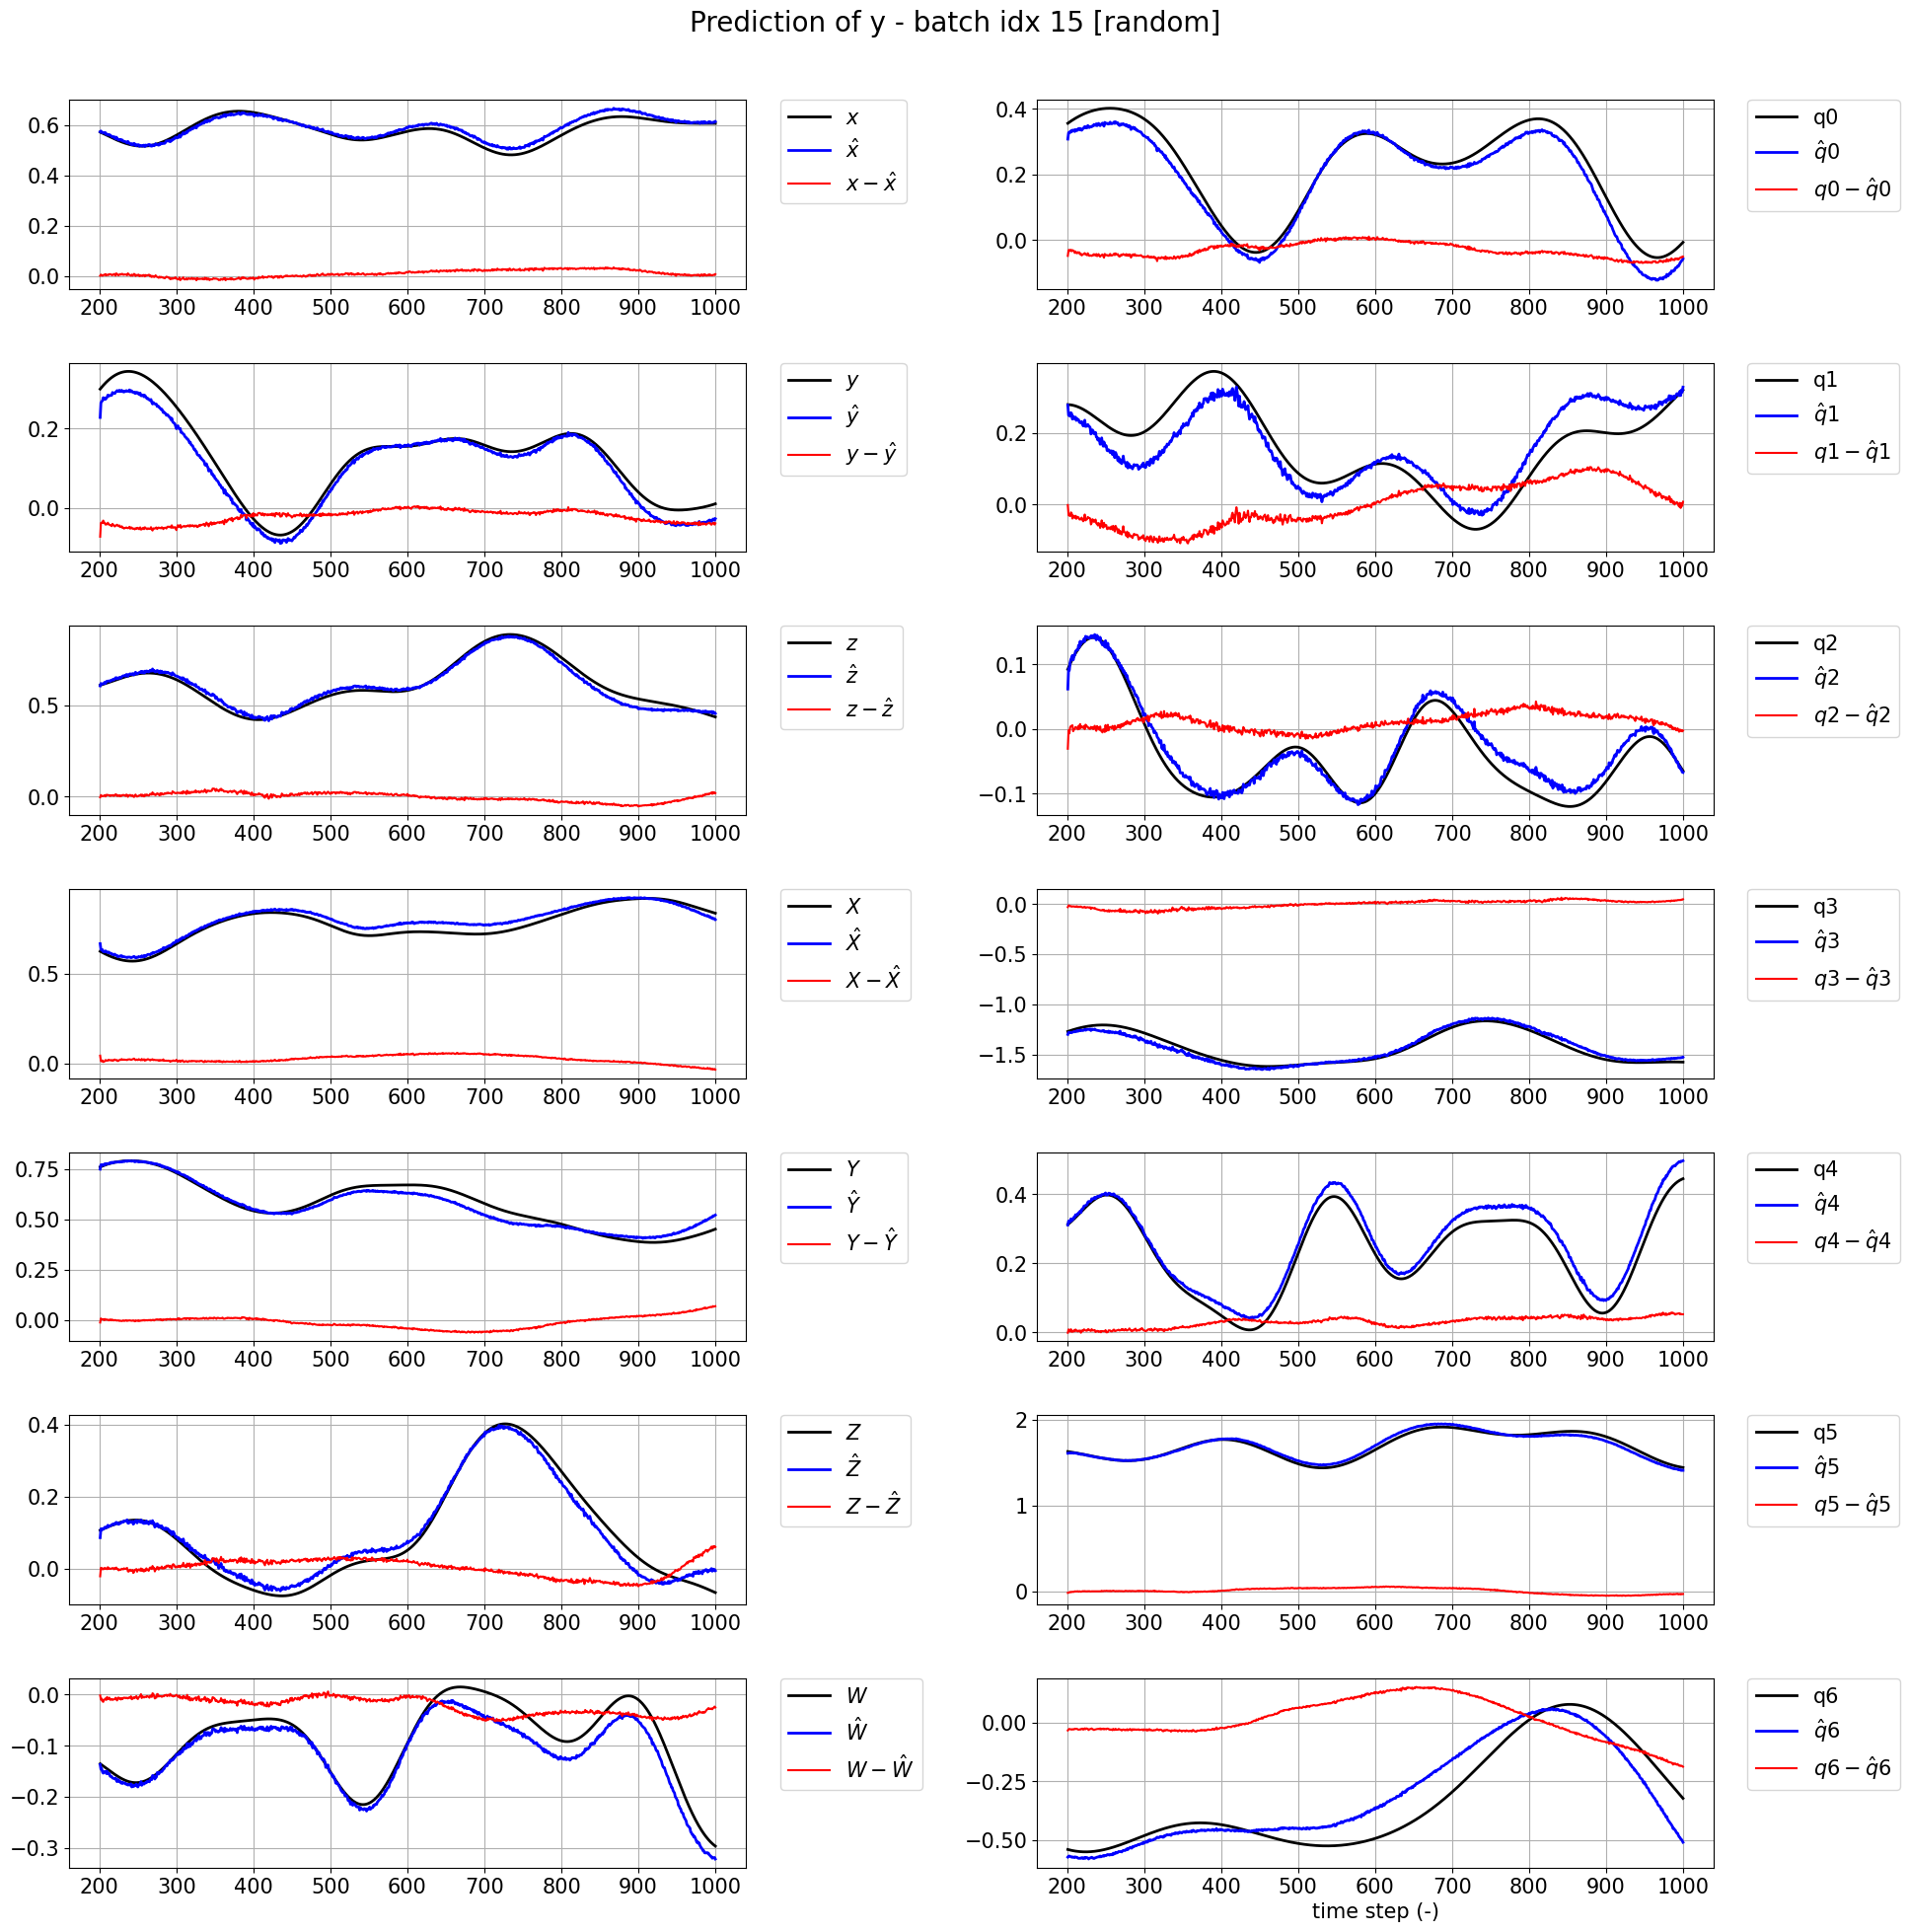

In [ ]:
for idx in range(len(test_idxs)):

    fig, axs = plt.subplots(int(ny/2), 2,figsize=(20, 20))
    fig.suptitle('Prediction of y - batch idx '+ str(test_idxs[idx]) + ' ['+ str(label_idxs[idx])+']',size = 20,y = .99)
    k = 0

    idx_plot = test_idxs[idx]

    for j in range(int(2)):
        for i in range(int(ny/2)):
            axs[i,j].plot(t, y_ground_truth[idx_plot, :, k] ,'k', label=labels_coordinates[k],linewidth=2)
            axs[i,j].plot(t, y_predicted[idx_plot, :, k], 'b', label=labels_pred[k],linewidth=2)
            axs[i,j].plot(t, sim_error[idx_plot, :, k], 'r', label=labels_error[k])
            axs[i,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            axs[i,j].grid(True)
            k=k+1

    plt.xlabel("time step (-)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout( pad = 2)

    if save_figure == True:
        plt.savefig(fig_path / f"{label_idxs[idx]}.png")


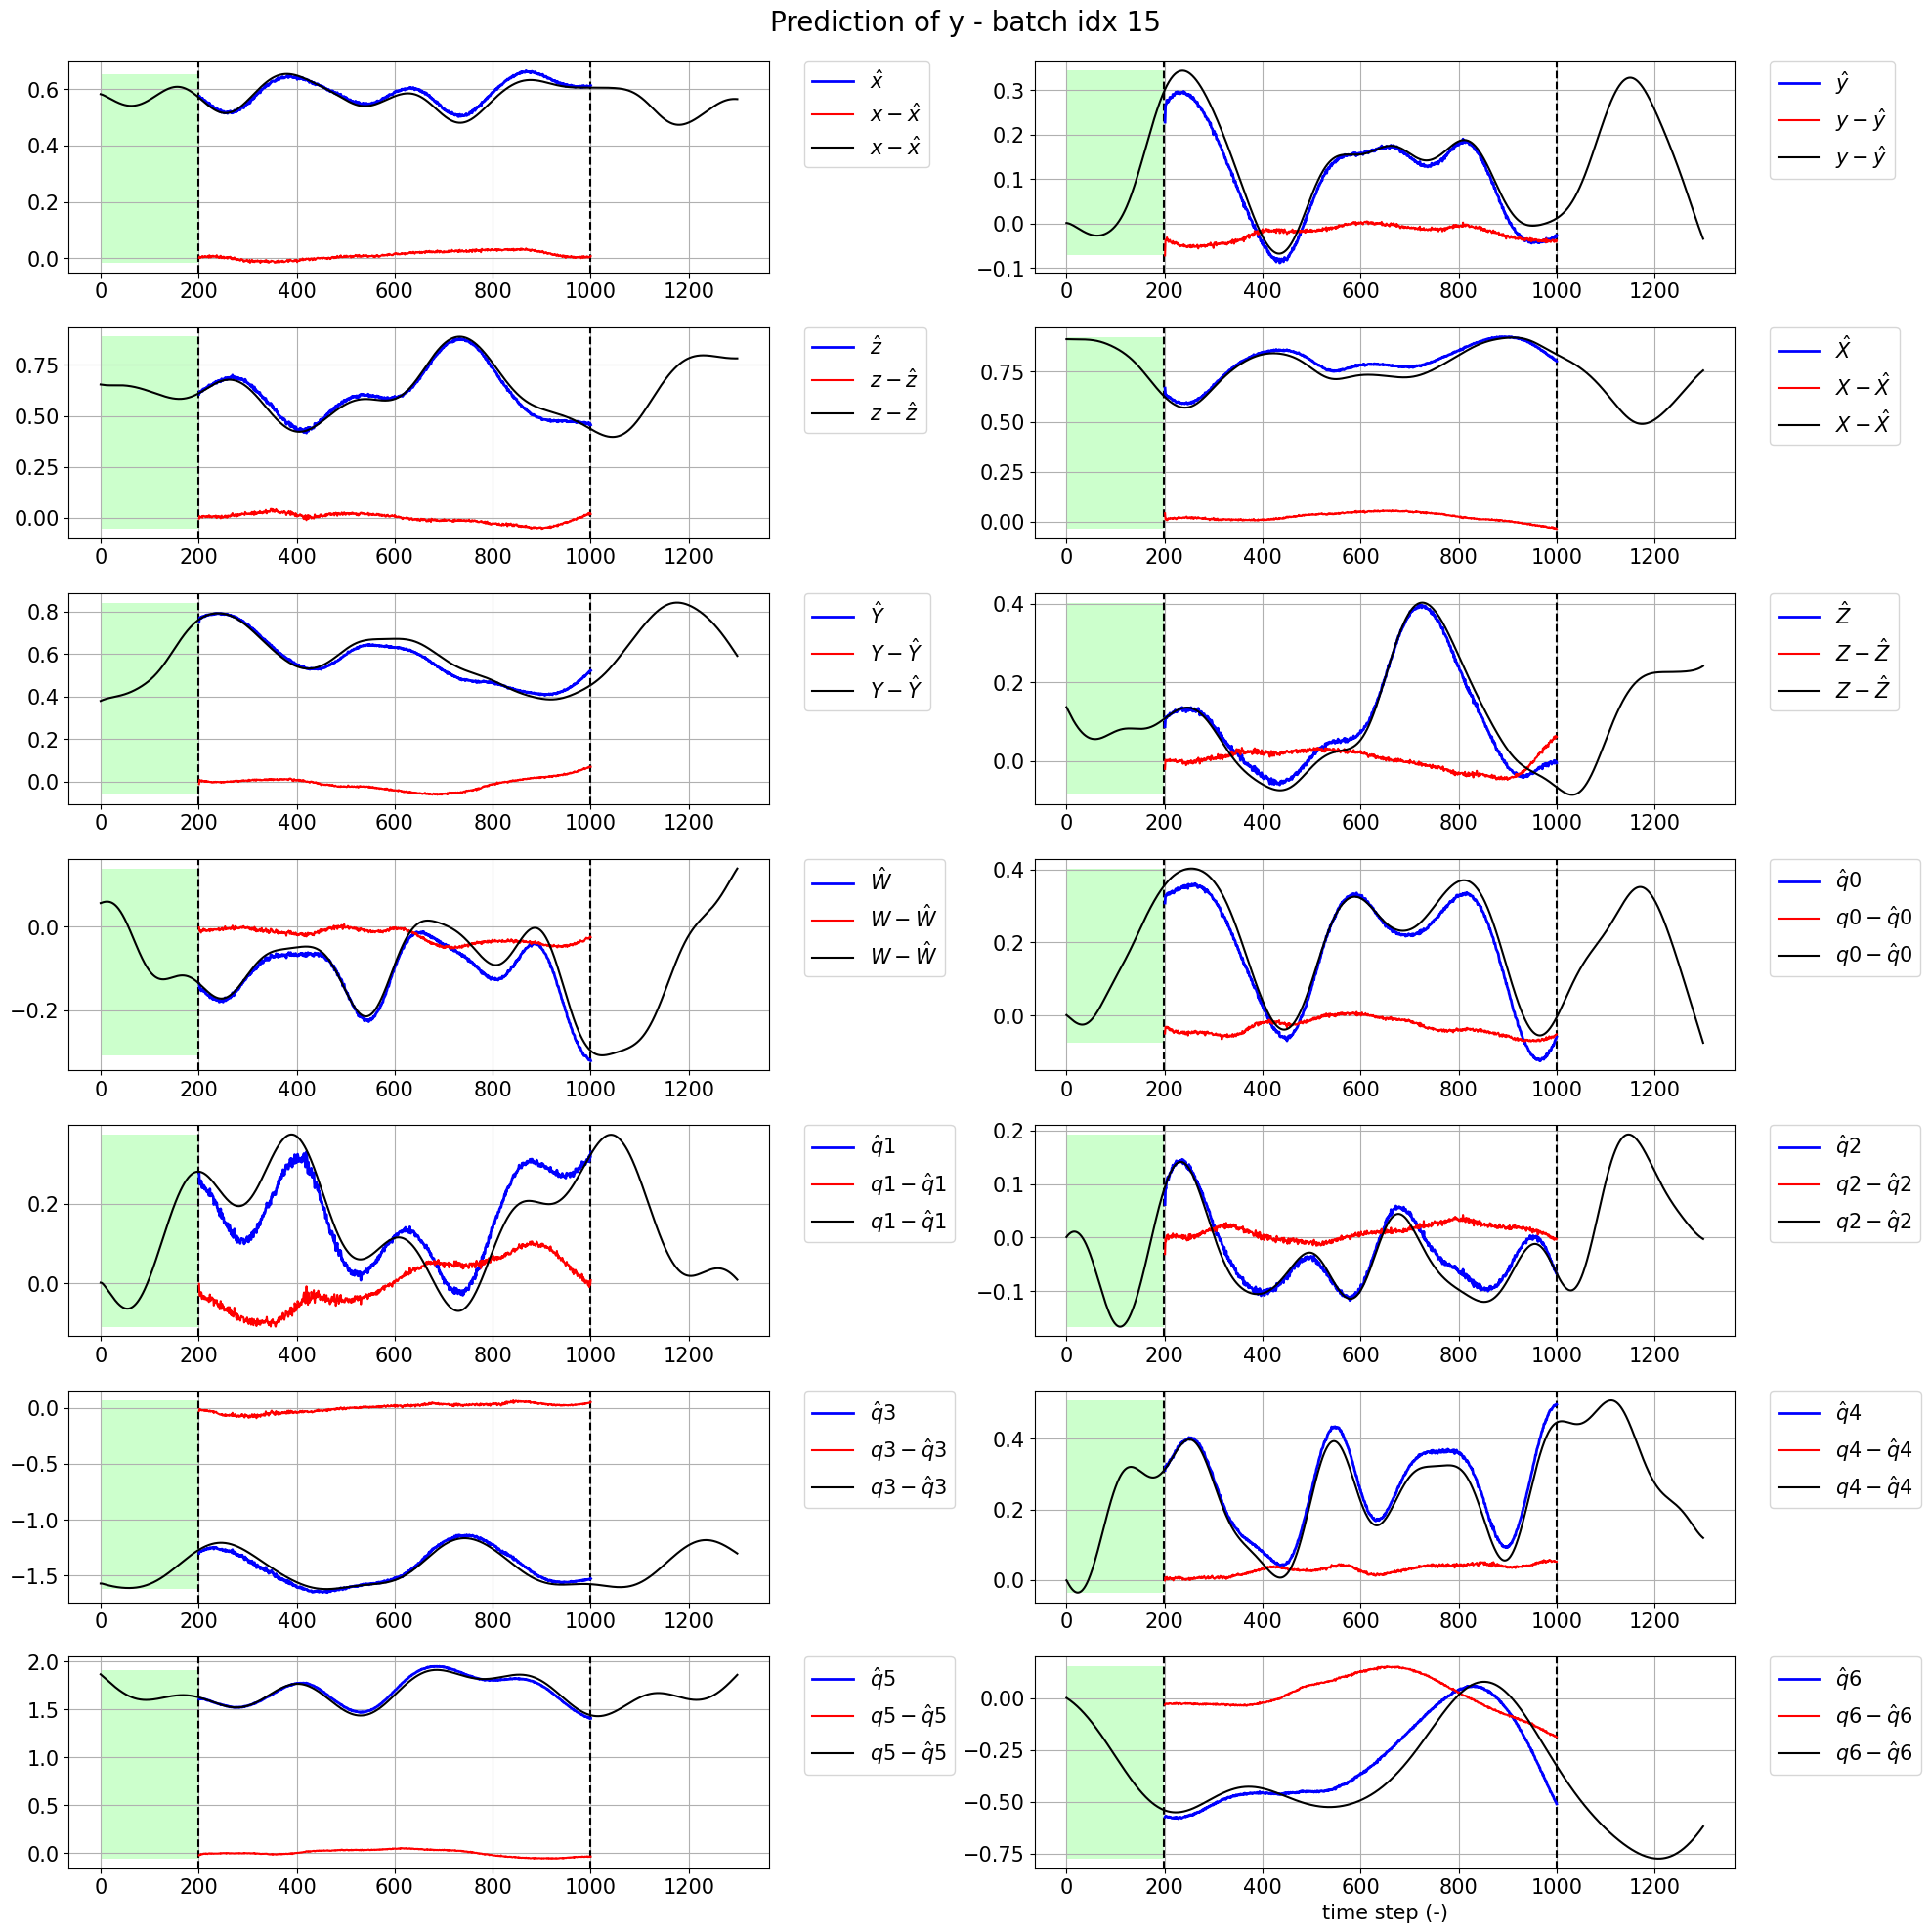

In [ ]:
t_context = np.arange(1, cfg.seq_len_ctx) 
t_prediction = np.arange(1, single_u_new.shape[0]+1) + cfg.seq_len_ctx
t_total = np.arange(0, position.shape[1])

fig, axs = plt.subplots(int(ny/2), 2,figsize=(20, 20))
fig.suptitle('Prediction of y - batch idx '+ str(random_idx),size = 20,y = .99)

k = 0
for i in range(int(ny/2)):
    for j in range(int(2)):
        # Plot context - green
        # axs[i,j].plot(t_context, position[idx,0:cfg.seq_len_ctx-1,k] ,'k',linewidth=2)
        min_value = min (min(position[random_idx, :, k]),min(sim_error[random_idx, :, k]))
        max_value = max (max(position[random_idx, :, k]),max(sim_error[random_idx, :, k]))
        axs[i,j].axvline(x = t_prediction[-1], color = 'k', linestyle='--')
        axs[i,j].axvline(x = t_context[-1], color = 'k', linestyle='--')
        axs[i,j].fill_between( t_context, min_value, max_value, facecolor='lime', alpha=0.2)
  
        # Plot prediction & error
        axs[i,j].plot(t_prediction, y_predicted[random_idx, :, k], 'b', label=labels_pred[k],linewidth=2)
        axs[i,j].plot(t_prediction, sim_error[random_idx, :, k], 'r', label=labels_error[k])
        # Plot entire Signal
        axs[i,j].plot(t_total, position[random_idx, :, k], 'k', label=labels_error[k])

        axs[i,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        axs[i,j].grid(True)
        k=k+1

plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

if save_figure == True:
    plt.savefig(fig_path / f"robot_{idx}_ctx.png")


In [ ]:
r_squared_mean_along_batches = np.ones(num_test)* r_squared_mean_along_y_dimensions.mean()
r_squared_std_along_batches = np.ones(num_test)* r_squared_std_along_y_dimensions.mean()
upper = np.ones(num_test)* ( r_squared_mean_along_batches + r_squared_std_along_batches )
lower = np.ones(num_test)* ( r_squared_mean_along_batches - r_squared_std_along_batches)

rmse_mean_along_batches = np.ones(num_test)* RMSE_mean_along_y_dimensions.mean()
rmse_std_along_batches = np.ones(num_test)* RMSE_std_along_y_dimensions.mean()
upper_rmse = np.ones(num_test)* ( rmse_mean_along_batches + rmse_std_along_batches )
lower_rmse = np.ones(num_test)* ( rmse_mean_along_batches - rmse_std_along_batches)

fit_index_along_batches = np.ones(num_test)*fit_index_along_y_dimensions.mean()
fit_index_std_along_batches = np.ones(num_test)*fit_index_std_along_y_dimensions.mean()
upper_fit = np.ones(num_test)* ( fit_index_along_batches + fit_index_std_along_batches )
lower_fit = np.ones(num_test)* ( fit_index_along_batches - fit_index_std_along_batches)

NRMSE_mean_along_batches = np.ones(num_test)*NRMSE_mean_along_y_dimensions.mean()
NRMSE_std_along_batches = np.ones(num_test)*NRMSE_std_along_y_dimensions.mean()
upper_NRMSE = np.ones(num_test)* ( NRMSE_mean_along_batches + NRMSE_std_along_batches)
lower_NRMSE = np.ones(num_test)* ( NRMSE_mean_along_batches - NRMSE_std_along_batches)

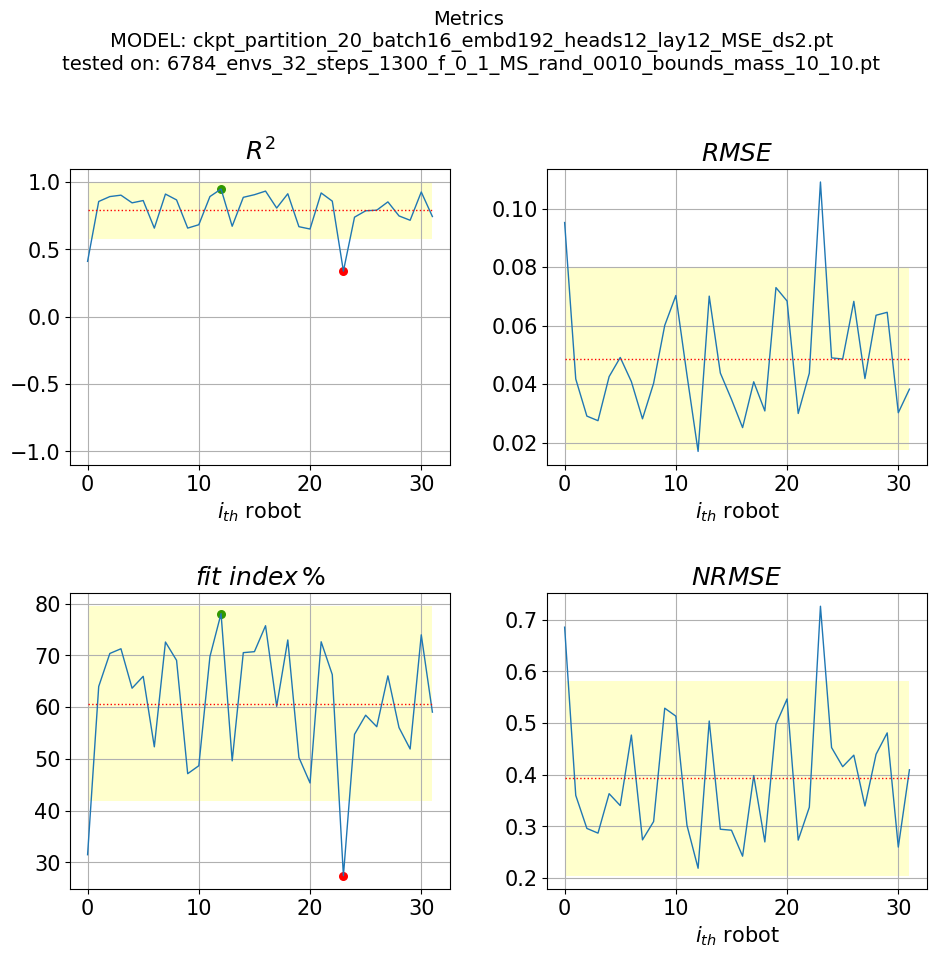

In [ ]:
fig,[[ax1, ax2],[ax3, ax4]]  = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle('Metrics'+ '\n MODEL: '+ model_name + 
             '\n tested on: ' + list_of_available_tensors[index_test] ,size = 14)

ax2.plot(RMSE_mean_along_y_dimensions,linewidth=1)
ax2.plot(rmse_mean_along_batches,'r',linewidth=1,linestyle='dotted') #{labels_coordinates[k]}
ax2.fill_between( range(0,control_action.shape[0]), upper_rmse, lower_rmse, facecolor='yellow', alpha=0.2)

ax1.plot(r_squared_mean_along_y_dimensions,linewidth=1)
ax1.plot(r_squared_mean_along_batches,'r',linewidth=1,linestyle='dotted') #{labels_coordinates[k]}
ax1.scatter(minR_squared_idx,r_squared_mean_along_y_dimensions[minR_squared_idx],marker='o', color='red', s=30)
ax1.scatter(maxR_squared_idx,r_squared_mean_along_y_dimensions[maxR_squared_idx],marker='o', color='green', s=30)   
ax1.fill_between( range(0,control_action.shape[0]), upper, lower, facecolor='yellow', alpha=0.2)


ax2.grid(True)
ax1.grid(True)
ax1.set_title('$R^{2}$')
ax2.set_title('$RMSE$')
ax1.set_ylim([-1.1, 1.1])
ax1.set(xlabel='$i_{th}$ robot ')
ax2.set(xlabel='$i_{th}$ robot')

ax3.plot(fit_index_along_y_dimensions,linewidth=1)
ax3.plot(fit_index_along_batches,'r',linewidth=1,linestyle='dotted') #{labels_coordinates[k]}
ax3.scatter(worst_fit_index_idx,fit_index_along_y_dimensions[worst_fit_index_idx],marker='o', color='red', s=30)
ax3.scatter(best_fit_index_idx,fit_index_along_y_dimensions[best_fit_index_idx],marker='o', color='green', s=30)
ax3.fill_between( range(0,num_test), upper_fit, lower_fit, facecolor='yellow', alpha=0.2)

ax4.plot(NRMSE_mean_along_y_dimensions,linewidth=1)
ax4.plot(NRMSE_mean_along_batches,'r',linewidth=1,linestyle='dotted') #{labels_coordinates[k]}
ax4.fill_between( range(0,num_test), upper_NRMSE, lower_NRMSE, facecolor='yellow', alpha=0.2)

ax3.grid(True)
ax4.grid(True)

ax3.set_title('$fit\,\,index\,\%$')
ax4.set_title('$NRMSE$')
# ax3.set_ylim([-100, 100])
ax4.set(xlabel='$i_{th}$ robot')
ax4.set(xlabel='$i_{th}$ robot')

fig.tight_layout(pad = 2)